In [129]:
# import libraries
import json
import numpy as np
import pandas as pd
import pickle
import operator
import collections
from dataparser import parse_json_file
from pandas.io.json import json_normalize
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 7 columns):
session_id        20022 non-null object
unix_timestamp    20022 non-null datetime64[ns]
cities            20022 non-null object
country           20022 non-null category
joining_date      20022 non-null datetime64[ns]
user_id           20022 non-null int64
access_date       20022 non-null object
dtypes: category(1), datetime64[ns](2), int64(1), object(3)
memory usage: 958.5+ KB


In [130]:
# Load dataset
file_path = 'city_search.json'
df = parse_json_file(file_path)
df.columns
df.info()
df.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 7 columns):
session_id        20022 non-null object
unix_timestamp    20022 non-null datetime64[ns]
cities            20022 non-null object
country           20022 non-null category
joining_date      20022 non-null datetime64[ns]
user_id           20022 non-null int64
access_date       20022 non-null object
dtypes: category(1), datetime64[ns](2), int64(1), object(3)
memory usage: 958.5+ KB


,session_id,unix_timestamp,cities,country,joining_date,user_id,access_date
0,X061RFWB06K9V,2015-09-17 15:28:28,"New York NY, Newark NJ",UK,2015-03-22,2024,2015-09-17
1,5AZ2X2A9BHH5U,2015-09-04 08:06:31,"New York NY, Jersey City NJ, Philadelphia PA",DE,2015-03-28,2853,2015-09-04
2,SHTB4IYAX4PX6,2015-08-29 10:18:10,San Antonio TX,UK,2015-03-06,10958,2015-08-29
3,JBRB8MZGTX3M4,2015-03-25 07:21:03,Edmonton AB,IT,2015-03-12,7693,2015-03-25
4,YJCMPURC2FL9C,2015-05-02 09:31:07,"Phoenix AZ, Houston TX",UK,2015-02-28,7506,2015-05-02
5,LKOKP80QD6BEO,2015-06-13 12:53:11,San Diego CA,ES,2015-03-04,3743,2015-06-13
6,YOVUIM79SGS5Y,2015-09-25 09:04:47,"Montreal QC, Chicago IL",Unknown,2015-03-02,8831,2015-09-25
7,SHXEY67QWKP9K,2015-05-16 08:48:24,"Calgary AB, New York NY",Unknown,2015-03-16,587,2015-05-16


In [23]:
# check missing data
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/20022)*100})
missing_data

,total_missing,perc_missing
session_id,0,0.0
unix_timestamp,0,0.0
cities,0,0.0
country,0,0.0
joining_date,0,0.0
user_id,0,0.0
access_date,0,0.0


first_date:  2015-02-28
last_date:  2015-10-02


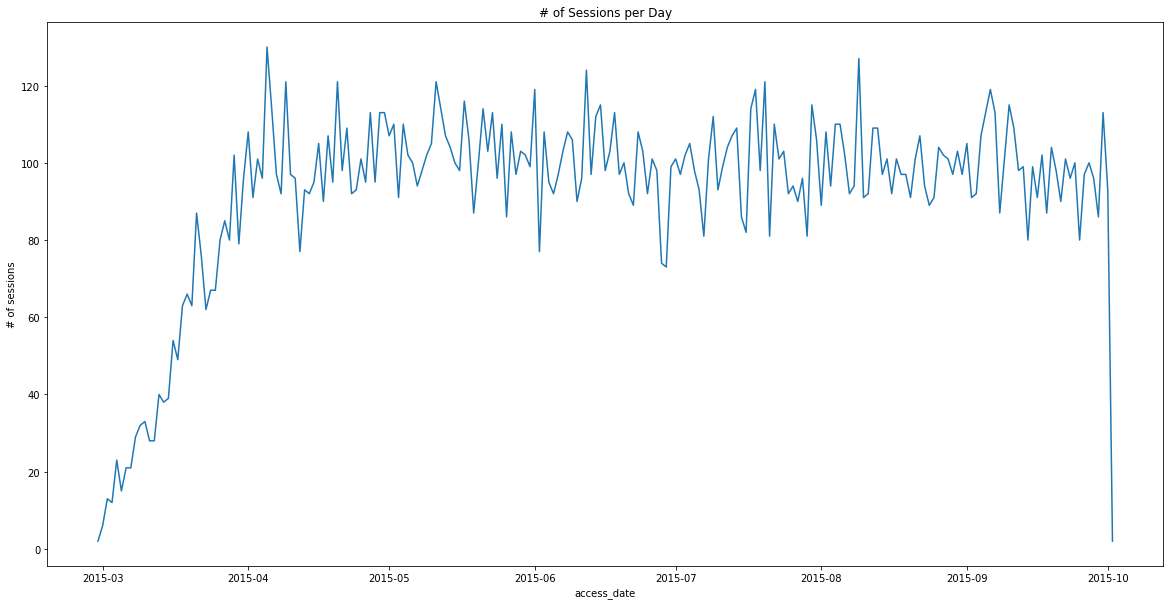

In [24]:
# Get the first day and the last day of the data
df_by_accessdate = df.groupby(by=["access_date"], axis = 0).count()
print('first_date: ', df_by_accessdate.index[0])
print('last_date: ', df_by_accessdate.index[-1])

# Plot the number of sessions by day 
daily_session_df = df.groupby(by=["access_date"], axis = 0).count()
fig, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_ylabel("# of sessions")
axes.set_xlabel("access_date")
axes.set_title("# of Sessions per Day")
axes.plot(daily_session_df["session_id"])

In [37]:
'''
Get the set of all searched cities and t
he corresponding searched times of each city
'''
searched_cities= df['cities'].unique()

cities_set = set() # the set of all searched cities
searched_city_dict = {} # the dictionary of "city:searched times" pair
for item in searched_cities: 
     for c in item.split(','):
        cities_set.add(c.strip())
        searched_city_dict[c.strip()] =  searched_city_dict.get(c.strip(),0) + 1
        

sorted_city = sorted(searched_city_dict.items(), key=operator.itemgetter(1))
sorted_city.reverse()
searched_city_dict = collections.OrderedDict(sorted_city)

print('The number of searched cities: ', len(cities_set))
print(searched_city_dict)

# These are all US and Canada cities

The number of searched cities:  89
OrderedDict([('New York NY', 286), ('Toronto ON', 249), ('Los Angeles CA', 217), ('Montreal QC', 196), ('Chicago IL', 187), ('Vancouver BC', 153), ('Houston TX', 153), ('Philadelphia PA', 125), ('Oshawa ON', 95), ('Saint Catharines-Niagara ON', 92), ('Jersey City NJ', 91), ('San Diego CA', 90), ('Newark NJ', 90), ('Baltimore MD', 84), ('Dallas TX', 84), ('OTTAWA ON', 82), ('San Antonio TX', 82), ('Santa Ana CA', 79), ('Indianapolis IN', 77), ('Hamilton ON', 76), ('Calgary AB', 76), ('Anaheim CA', 74), ('Long Beach CA', 73), ('Edmonton AB', 71), ('Riverside CA', 69), ('Fort Wayne IN', 67), ('Victoria BC', 67), ('Seattle WA', 66), ('Detroit MI', 65), ('Columbus OH', 64), ('Toledo OH', 60), ('Austin TX', 60), ('Phoenix AZ', 58), ('Arlington TX', 56), ('Kitchener ON', 55), ('Buffalo NY', 54), ('Fort Worth TX', 54), ('WASHINGTON DC', 53), ('Jacksonville FL', 48), ('Portland OR', 47), ('Cincinnati OH', 45), ('San Jose CA', 45), ('Boston MA', 43), ('Windsor 

In [63]:
# Get group by country information
group_by_country = df.groupby('country')

# Create city×country data frame
rows = [] # For a city, the number of searched times by each country
index_to_country_dict = {} # Dictionary of "index:country" pair
country_to_usercount_dict = {}
index=0
for name,group in group_by_country:
   d = dict.fromkeys(cities_set, 0)
   country_to_usercount_dict[name] = group['user_id'].nunique()
   for items in group['cities'].iteritems(): 
      for c in items[1].split(','):
        d[c.strip()] = d.get(c.strip()) + 1
   rows.append(d)
   index_to_country_dict[index]=name
   index = index+1

# city×country data frame
df_city_by_country = pd.DataFrame.from_dict(rows, orient='columns')
df_city_by_country.rename(index = index_to_country_dict, inplace=True)
df_city_by_country.head()

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
DE,44,22,1,45,5,48,0,33,31,99,...,22,603,3,3,246,25,0,15,3,12
ES,27,8,3,15,1,21,1,16,10,66,...,11,327,0,0,148,20,4,8,1,6
FR,26,7,2,30,3,21,2,19,18,60,...,15,377,0,2,149,19,3,9,0,10
IT,26,17,1,19,3,30,0,15,15,45,...,6,294,3,2,134,26,3,5,0,5
UK,51,26,6,53,8,40,2,24,26,106,...,18,577,4,2,213,29,3,18,0,14


Average number of sessions per user:  3.4658127055565173


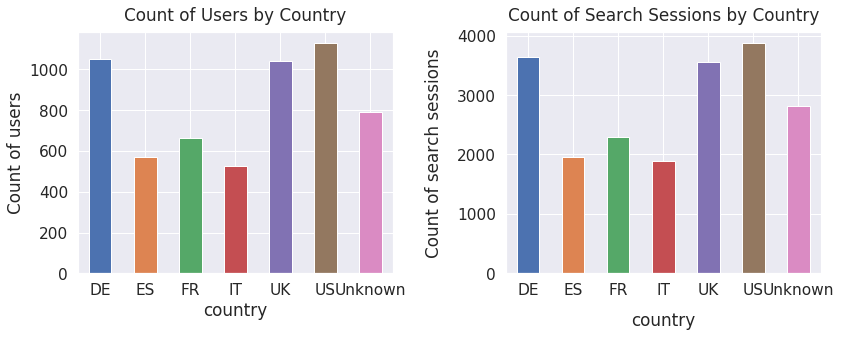

In [60]:
# Plot user counts by country
user_count_by_country = pd.Series(country_to_usercount_dict).sort_index()
sns.set(font_scale=1.4)
plt.subplot(1, 2, 1)
user_count_by_country.plot(kind="bar",title="Count users by country",figsize=(12,5),rot=0)
plt.xlabel("country")
plt.ylabel("Count of users")
plt.title("Count of Users by Country", y=1.02)

# Plot session counts by country
sns.set(font_scale=1.4)
plt.subplot(1, 2, 2)
country_series = df['country'].value_counts().sort_index()
country_series.plot(kind="bar",title="country distribution",figsize=(12,5),rot=0)
plt.xlabel("country", labelpad=14)
plt.ylabel("Count of search sessions", labelpad=14)
plt.title("Count of Search Sessions by Country", y=1.02)

plt.tight_layout()

avg_session_per_user = df.shape[0]/df['user_id'].nunique()
print('Average number of sessions per user: ', avg_session_per_user)


In [73]:
# country×city data frame
df_country_by_city = df_city_by_country.T
df_country_by_city.head()
df_country_by_city.describe()

,DE,ES,FR,IT,UK,US,Unknown
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,67.449438,35.977528,42.325843,35.191011,66.370787,71.752809,51.898876
std,144.256795,77.467439,89.425156,74.976190,139.695479,150.998366,110.015396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2.000000,2.000000,3.000000,6.000000,5.000000,3.000000
50%,20.000000,10.000000,10.000000,9.000000,18.000000,18.000000,14.000000
75%,62.000000,35.000000,41.000000,32.000000,65.000000,68.000000,48.000000
max,991.000000,530.000000,599.000000,510.000000,960.000000,1017.000000,754.000000


In [79]:
# For each country, calculate the percentage of searched times for each city as compared to 
# the total number of searches for that country
session_per_country_list = df['country'].value_counts()
df_country_by_city['US_sr'] = df_country_by_city['US']/session_per_country_list[0]
df_country_by_city['DE_sr'] = df_country_by_city['DE']/session_per_country_list[1]
df_country_by_city['UK_sr'] = df_country_by_city['UK']/session_per_country_list[2]
df_country_by_city['Unknown_sr'] = df_country_by_city['Unknown']/session_per_country_list[3]
df_country_by_city['FR_sr'] = df_country_by_city['FR']/session_per_country_list[4]
df_country_by_city['ES_sr'] = df_country_by_city['ES']/session_per_country_list[5]
df_country_by_city['IT_sr'] = df_country_by_city['IT']/session_per_country_list[6]

# Get the top 25 cities searched most by Unknown country
df_country_by_city.nlargest(30, 'Unknown').head(23)

,DE,ES,FR,IT,UK,US,Unknown,US_sr,DE_sr,UK_sr,Unknown_sr,FR_sr,ES_sr,IT_sr
New York NY,991,530,599,510,960,1017,754,0.279549,0.507424,0.417755,0.400638,0.168495,0.136739,0.180851
Toronto ON,603,327,377,294,577,644,457,0.177020,0.308756,0.251088,0.242827,0.106048,0.084365,0.104255
Los Angeles CA,453,270,321,278,479,527,344,0.144860,0.231951,0.208442,0.182784,0.090295,0.069659,0.098582
Montreal QC,450,220,270,222,414,426,334,0.117097,0.230415,0.180157,0.177471,0.075949,0.056760,0.078723
Chicago IL,356,182,223,200,344,389,285,0.106927,0.182284,0.149695,0.151435,0.062729,0.046956,0.070922
Houston TX,268,141,150,124,243,258,210,0.070918,0.137225,0.105744,0.111583,0.042194,0.036378,0.043972
Vancouver BC,246,148,149,134,213,279,207,0.076690,0.125960,0.092689,0.109989,0.041913,0.038184,0.047518
Philadelphia PA,207,90,110,96,192,216,145,0.059373,0.105991,0.083551,0.077046,0.030942,0.023220,0.034043
Phoenix AZ,136,46,89,63,134,153,102,0.042056,0.069636,0.058312,0.054198,0.025035,0.011868,0.022340
San Diego CA,126,58,83,67,128,142,101,0.039032,0.064516,0.055701,0.053666,0.023347,0.014964,0.023759


In [80]:
# Get the top 15 cities searched least by Unknown country
df_country_by_city.nsmallest(15, 'Unknown').head(15)

,DE,ES,FR,IT,UK,US,Unknown,US_sr,DE_sr,UK_sr,Unknown_sr,FR_sr,ES_sr,IT_sr
Birmingham AL,0,1,2,0,2,2,0,0.000550,0.000000,0.000870,0.000000,0.000563,0.000258,0.000000
Chandler AZ,9,5,6,4,16,15,0,0.004123,0.004608,0.006963,0.000000,0.001688,0.001290,0.001418
Greensboro NC,0,0,0,1,0,1,0,0.000275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000355
Kansas City MO,1,0,0,0,0,1,0,0.000275,0.000512,0.000000,0.000000,0.000000,0.000000,0.000000
Lincoln NE,2,0,0,0,0,1,0,0.000275,0.001024,0.000000,0.000000,0.000000,0.000000,0.000000
Memphis TN,0,1,0,0,1,1,0,0.000275,0.000000,0.000435,0.000000,0.000000,0.000258,0.000000
New Orleans LA,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000281,0.000000,0.000000
Omaha NE,1,0,0,0,0,2,0,0.000550,0.000512,0.000000,0.000000,0.000000,0.000000,0.000000
Pittsburgh PA,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000355
Charlotte NC,0,0,0,1,0,1,1,0.000275,0.000000,0.000000,0.000531,0.000000,0.000000,0.000355


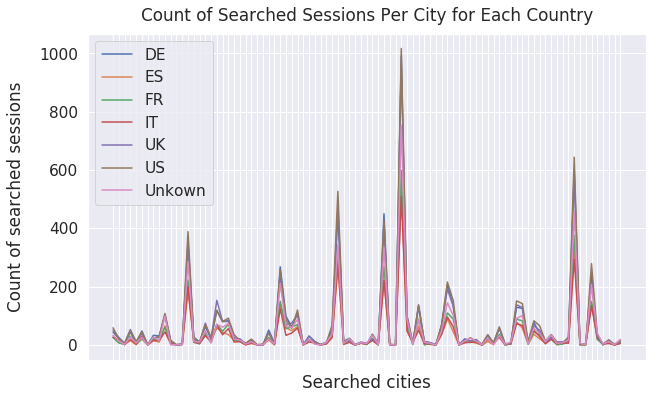

In [83]:
# Plot the number of searched session vs cities for each country
plt.figure(figsize=(10,6))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.plot(df_country_by_city.index, df_country_by_city["DE"], label='DE')
plt.plot(df_country_by_city.index, df_country_by_city["ES"], label='ES')
plt.plot(df_country_by_city.index, df_country_by_city["FR"], label='FR')
plt.plot(df_country_by_city.index, df_country_by_city["IT"], label='IT')
plt.plot(df_country_by_city.index, df_country_by_city["UK"], label='UK')
plt.plot(df_country_by_city.index, df_country_by_city["US"], label='US')
plt.plot(df_country_by_city.index, df_country_by_city["Unknown"], label='Unkown')
plt.xlabel("Searched cities", labelpad=14)
plt.ylabel("Count of searched sessions", labelpad=14)
plt.title("Count of Searched Sessions Per City for Each Country", y=1.02);
plt.legend()

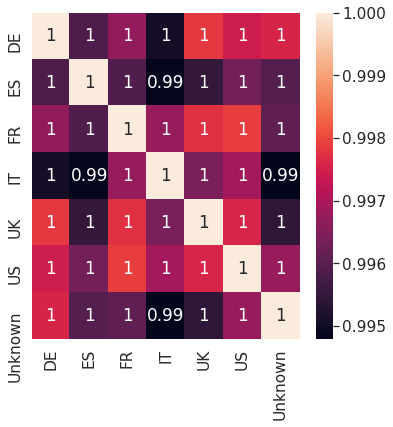

In [90]:
plt.subplots(figsize=(6,6))
sns.heatmap(df_country_by_city[df_country_by_city.columns[0:7]].corr(), annot=True)
# It shows that People of all countries have similar interests regarding cities based on the number of search


# #Conclusion: 
The Unknown country is Canada. Since Canada in north America and have large population as compared to those of European country. Canada is close to US, beside canadian cities, canadian people likes to visit US cities. Canadian people will show more passion to New York as compared to US people.